In [134]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statistics import mode
import math
%matplotlib inline


In [135]:
matches = pd.read_csv('matches.csv')
delivery = pd.read_csv('deliveries.csv')
match_ids = matches[matches.season >= 2016]['id'].unique()
matches1 = matches[(matches.season >= 2016) & (matches['result']=='normal')]
matches1 = matches1.drop(['player_of_match','venue','umpire1','umpire2','umpire3', 'dl_applied', 'season', 'city', 'date', 'result'], axis=1)
matches1.dropna(inplace=True)

In [136]:
def team_correction(row):
    row = row.strip()
    if row == 'Delhi Daredevils':
        return 'Delhi Capitals'
    if row == 'Rising Pune Supergiants':
        return 'Rising Pune Supergiant'
    return row

for col in ['team1', 'team2', 'winner', 'toss_winner']:
    matches1[col] = matches1[col].apply(team_correction)
    

In [137]:
team_1 = 'Mumbai Indians'
team_2 = 'Royal Challengers Bangalore'

In [138]:
delivery = delivery[delivery.match_id.apply(lambda x: True if x in match_ids else False)]
for col in ['batting_team', 'bowling_team']:
    delivery[col] = delivery[col].apply(team_correction)

delivery.fillna(0, inplace=True)
delivery['player_dismissed'] = delivery['player_dismissed'].apply(lambda x: 0 if x==0 else 1)

delivery['batsman_runs'] = delivery['batsman_runs'].apply(lambda x: x-1 if ((x==7) or (x==5)) else x)

# Winning Probability of Teams

Text(0.5, 1.0, 'RCB Total Runs Score Stats Per Count')

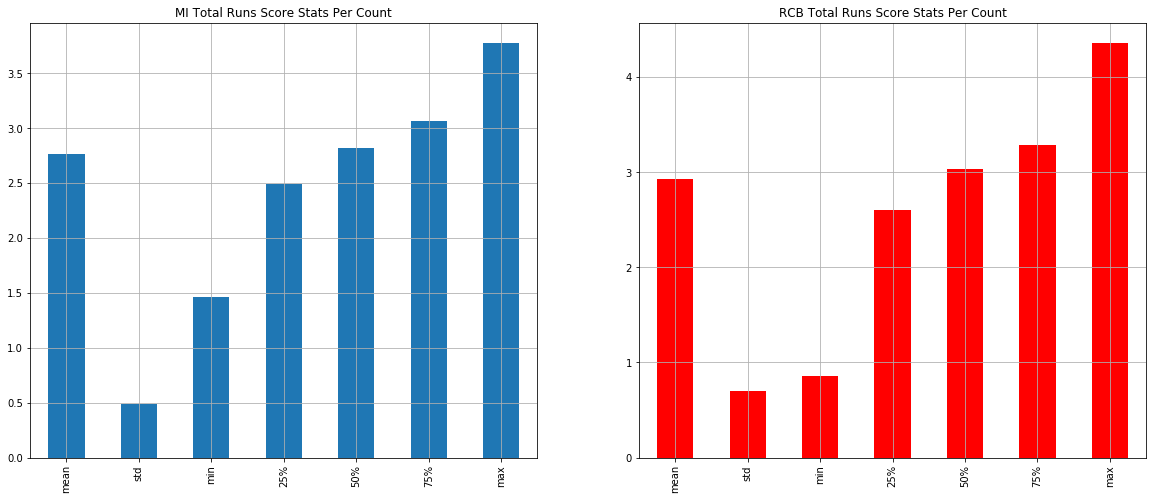

In [139]:
fig, ax = plt.subplots(1,2, figsize=(20,8))
mi_runs = delivery[delivery['batting_team']==team_1].groupby('match_id').sum()['total_runs']
rcb_runs = delivery[delivery['batting_team']==team_2].groupby('match_id').sum()['total_runs']
(mi_runs.describe()[1:]/srh_runs.describe()[0]).plot(ax=ax[0], kind='bar', grid=True)
(rcb_runs.describe()[1:]/dc_runs.describe()[0]).plot(ax=ax[1], kind='bar', grid=True, color='red')
ax[0].set_title("MI Total Runs Score Stats Per Count")
ax[1].set_title("RCB Total Runs Score Stats Per Count")

Text(0.5, 1.0, 'Percentage of Winning')

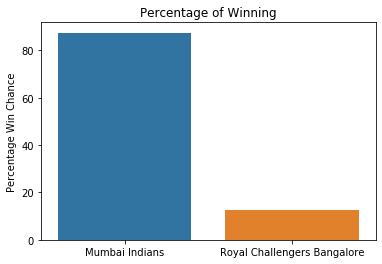

In [140]:
wins = pd.DataFrame(matches1[(matches1['team1'].isin([team_1, team_2])) & (matches1['team2'].isin([team_1, team_2]))]['winner'].value_counts())
wins['Percentage Win Chance'] = (wins['winner']/sum(wins['winner']))*100
sns.barplot(wins.index, y=wins['Percentage Win Chance'])
plt.title('Percentage of Winning')

# Bowlers with 2 wickets

In [141]:
mi_team = ['RG Sharma', 'Q de Kock', 'SA Yadav', 'Ishan Kishan', 'HH Pandaya', 'KH Pandaya', 'NM Coulter-Nile', 'RD Chahar', 'JJ Bumrah', 'TA Boult']
rcb_team = ['S Dube' ,'Washington Sundar','AB de Villiers' ,'V Kohli', 'AJ Finch', 'YS Chahal', 'CH Morris', 'S Dube', 'Mohammed Siraj']

In [142]:
bowler_squad = list()
for bowler in (mi_team+rcb_team):
    for match in delivery[(delivery['bowler']==bowler) & (delivery['player_dismissed']==1)]['match_id'].unique():
        wickets = delivery[(delivery['bowler']==bowler) & (delivery['player_dismissed']==1) & (delivery['match_id']==match)]['player_dismissed'].sum()   
        bowler_squad.append([bowler, wickets])

In [144]:
bowler_squad_df = pd.DataFrame(data=bowler_squad, columns=['Name', 'Wickets in Match'])
bowler_squad_df.groupby('Name').median()

,Wickets in Match
Name,
CH Morris,2
JJ Bumrah,1
Mohammed Siraj,1
NM Coulter-Nile,2
RD Chahar,1
TA Boult,1
Washington Sundar,1
YS Chahal,1


In [143]:
bowler = delivery[delivery['bowler'].isin(mi_team+rcb_team)]
pd.DataFrame(data=bowler.groupby('bowler').sum()['player_dismissed']*100/bowler.groupby('bowler').count()['player_dismissed'])
#Ratio of total Wickets by Bowlers to total matches

,player_dismissed
bowler,
CH Morris,6.084656
JJ Bumrah,5.606813
Mohammed Siraj,5.136986
NM Coulter-Nile,7.380074
RD Chahar,4.504505
S Dube,0.000000
TA Boult,4.991948
V Kohli,0.000000
Washington Sundar,4.748603


# Economy Rate

In [145]:
bowler_squad_ER = list()
for bowler in (mi_team+rcb_team):
    for match_id in delivery[(delivery['bowler']==bowler)]['match_id'].unique():
        match = delivery[(delivery['bowler']==bowler) & (delivery['match_id']==match_id)]  
        ER = sum(match['total_runs'])*6/len(match)
        if len(match) >=6:
            bowler_squad_ER.append([bowler, ER])

In [146]:
bowler_ER_df = pd.DataFrame(data=bowler_squad_ER, columns=['Name', 'ER'])
bowler_ER_df.groupby('Name').median()

,ER
Name,
CH Morris,8.126667
JJ Bumrah,7.176923
Mohammed Siraj,9.428571
NM Coulter-Nile,7.346154
RD Chahar,6.750000
S Dube,5.000000
TA Boult,8.708333
V Kohli,9.750000
Washington Sundar,7.708333


# Strike Rate

In [147]:
batsman_squad_SR = list()
for batsman in (mi_team+rcb_team):
    for match_id in delivery[(delivery['batsman']==batsman)]['match_id'].unique():
        match = delivery[(delivery['batsman']==batsman) & (delivery['match_id']==match_id)]
        team = match['batting_team'].unique()[0]
        if len(match)>10: 
            if len(match[match['batsman_runs'].isin([4, 6])]) > 3:
                SR = sum(match['batsman_runs'])*100/len(match)
                batsman_squad_SR.append([batsman, SR, team])

In [148]:
batsman_SR_df = pd.DataFrame(data=batsman_squad_SR, columns=['Name', 'SR', 'Team'])
batsman_SR_df.groupby(['Team', 'Name']).median()

SR
Team                        Name                         
Delhi Capitals              CH Morris          172.727273
                            Q de Kock          137.500000
Gujarat Lions               AJ Finch           154.166667
                            Ishan Kishan       137.310606
Kings XI Punjab             AJ Finch           134.285714
Kolkata Knight Riders       SA Yadav           149.305556
Mumbai Indians              Ishan Kishan       166.341829
                            Q de Kock          151.851852
                            RG Sharma          143.589744
Royal Challengers Bangalore AB de Villiers     177.122153
                            Q de Kock          140.170279
                            V Kohli            147.368421
                            Washington Sundar  176.190476

Text(0.5, 1.0, ' Wickets Fall in matches played against each other')

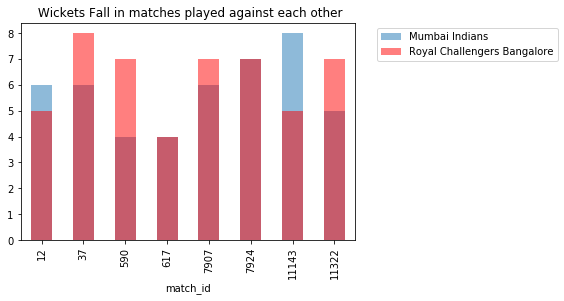

In [149]:
delivery[(delivery['batting_team']==team_1) & (delivery['bowling_team']==team_2)].groupby('match_id').sum()['player_dismissed'].plot(kind='bar', alpha=0.5, label=team_1)
delivery[(delivery['batting_team']==team_2) & (delivery['bowling_team']==team_1)].groupby('match_id').sum()['player_dismissed'].plot(kind='bar', alpha=0.5, color='red', label=team_2)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.title(" Wickets Fall in matches played against each other")

Text(0.5, 1.0, 'Histogram of Wickets Fall against per match')

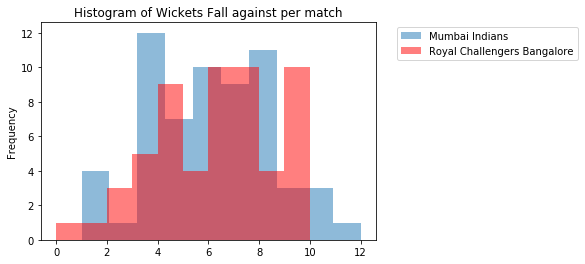

In [150]:
delivery[(delivery['batting_team']==team_1)].groupby('match_id').sum()['player_dismissed'].plot(kind='hist', alpha=0.5, label=team_1)
delivery[(delivery['batting_team']==team_2)].groupby('match_id').sum()['player_dismissed'].plot(kind='hist', alpha=0.5, color='red', label=team_2)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.title("Histogram of Wickets Fall against per match")

Wickets loose will be around 4-5 for both the teams. So, that suggests that batsman with past high strike rates would be playing except some bowlers. So, considering 3 boundaries situation(this would not be eligible in opening batsman players because there is less chance of hitting 3 boundaries before getting out), the range will be around 3 to 5. 

# Runs in powerplay

Text(0.5, 1.0, 'Scores per match in powerplay against each other')

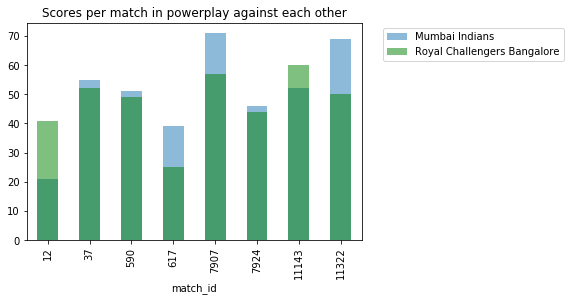

In [151]:
delivery[(delivery['batting_team']==team_1) & (delivery['over']<=6) & (delivery['bowling_team']==team_2)].groupby('match_id').sum()['total_runs'].plot(kind='bar', alpha=0.5, label=team_1)
delivery[(delivery['batting_team']==team_2) & (delivery['over']<=6) & (delivery['bowling_team']==team_1)].groupby('match_id').sum()['total_runs'].plot(kind='bar', alpha=0.5, label=team_2, color='green')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.title("Scores per match in powerplay against each other")

Text(0.5, 1.0, 'Difference in Runs during powerplay')

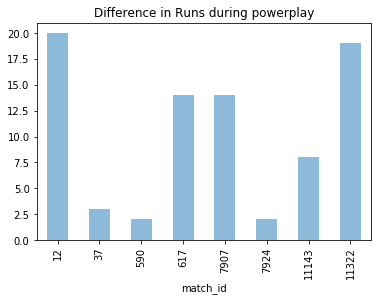

In [152]:
abs(delivery[(delivery['batting_team']==team_1) & (delivery['over']<=6) & (delivery['bowling_team']==team_2)].groupby('match_id').sum()['total_runs']
    - delivery[(delivery['batting_team']==team_2) & (delivery['over']<=6) & (delivery['bowling_team']==team_1)].groupby('match_id').sum()['total_runs']).plot(kind='bar', alpha=0.5)
    
plt.title('Difference in Runs during powerplay')

Taking mean range: The range will be 6 - 14

# Summary

- Using central tendency measure and winners column, the percentage chance of winning when playing against each other was calculated and compared. 
- Wickets by each bowler in each match where a bowler has taken at least 1 wicket were calculated and the median was taken for each bowler which estimated the number of bowlers to take 2 wickets. 
- Taking predicted bowlers playing today, their economy rate for each of their match was calculated and the median was taken. 
- The predicted batsmen playing today was considered and data was filtered per batsman and then using batsman score and balls faced by him per match the strike rate was calculated for different matches. Then, the batsman median strike rate was considered. Using, the predicted number of wickets fall in today's match, the prediction of a batsman playing was taken and the answer was calculated. 
- The runs of teams against each other in powerplay were calculated and graphed to find out the mean range of difference between their runs. 